# AutoEncoder Adversario

## Preparacion del entorno

Librerias

In [1]:
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from keras import Sequential
from keras.applications import mobilenet
from keras.layers import Input, Dense, LeakyReLU, GlobalAveragePooling2D, Reshape
import numpy as np
import matplotlib.pyplot as plt

Num GPUs Available:  1


Funcion para extraer los datos de los ficheros

In [2]:
# https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin')
    return dict

Extraemos los datos del fichero.

In [3]:
batch1 = unpickle("Input\cifar-10-batches-py\data_batch_1")
batch2 = unpickle("Input\cifar-10-batches-py\data_batch_2")
batch3 = unpickle("Input\cifar-10-batches-py\data_batch_3")
batch4 = unpickle("Input\cifar-10-batches-py\data_batch_4")
batch5 = unpickle("Input\cifar-10-batches-py\data_batch_5")

En cifar10 los datos estan almacenados en un diccionario que contiene el nombre del lote, las etiquetas para clasificacion, los datos (imagenes) y los nombres de fichero correspondientes.

In [4]:
print(batch1.keys())
for i in batch1:
    print(i, type(batch1[i]))

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
batch_label <class 'str'>
labels <class 'list'>
data <class 'numpy.ndarray'>
filenames <class 'list'>


Las imagenes vienen en el modo ``channelsfirst``, en este modo, tenemos 3 matrices de la dimension de la imagen, una para cada canal. Muchas de las funciones admiten por defecto el modo ``chanelslast`` en el que tenemos una matriz de la dimension de la imagen y cada posicion tiene un vector con los codigos de color de cada punto.

Por simplicidad, como paso de preprocesamiento, voy a transformar las imagenes de ``channelsfirst`` a ``channelslast``.

In [5]:
# https://www.binarystudy.com/2021/09/how-to-load-preprocess-visualize-CIFAR-10-and-CIFAR-100.html
imagen = batch1["data"][0]
imagen = imagen.reshape(3,32,32)
imagen=imagen.transpose(1,2,0)
print(imagen.shape)

(32, 32, 3)


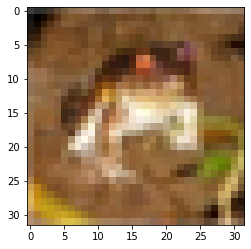

In [6]:
plt.imshow(imagen)

## Preparacion de los datos

In [7]:
print(batch1["data"].shape)
X_train = batch1["data"].reshape(10000, 3, 32, 32)
X_train = np.concatenate((X_train, batch2["data"].reshape(10000, 3, 32, 32)))
X_train = np.concatenate((X_train, batch3["data"].reshape(10000, 3, 32, 32)))
X_train = np.concatenate((X_train, batch4["data"].reshape(10000, 3, 32, 32)))
X_train = np.concatenate((X_train, batch5["data"].reshape(10000, 3, 32, 32)))
X_train = X_train.transpose(0,2,3,1)
X_train=X_train/255

(10000, 3072)


(50000, 32, 32, 3)


<Figure size 432x288 with 0 Axes>

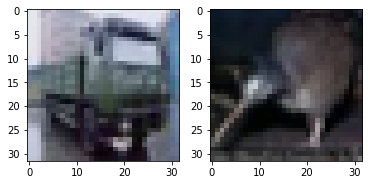

In [8]:
print(X_train.shape)
plt.figure()
f, arrx = plt.subplots(1,2)
arrx[0].imshow(X_train[np.random.randint(0,X_train.shape[0])])
arrx[1].imshow(X_train[np.random.randint(0,X_train.shape[0])])

## Arquitectura del ``Autoencoder``

### Encoder

El ``encoder`` va a ser un modelo basado en ``transfer learning``, vamos a tomar la red de ``mobilenet``, entranada para imagenes de ``imagenet`` sin las capa de clasificacion final, con una entrada de tamaño _img\_shape_ y en el output colocamos la 'representacion latente' una codificacion de la imagen que nos permitiría reconstruirla con un ``decoder``.

In [9]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/preprocess_input
# https://keras.io/guides/transfer_learning/
def build_encoder(dim_latente, img_shape):
    inputs = Input(shape=img_shape)
    x=tf.cast(inputs, tf.float32)
    #x=keras.applications.mobilenet.preprocess_input(x)  #dataformat por defecto es chanel last
    core = mobilenet.MobileNet(input_shape=(img_shape), weights="imagenet", include_top=False)
    core.trainable = False
    model = core(x, training=False)
    model = GlobalAveragePooling2D()(model)
    repr_latente = keras.layers.Dense(dim_latente)(model)
    return keras.Model(inputs, repr_latente)


### Decoder

El ``decoder`` toma la codificacion latente y decodifica en una imagen. En este caso es una configuracion incremental de capas densas, terminando en una del tamaño de la imagen.

In [10]:
def build_myDecoder(dim_latente, img_shape):
    model = keras.Sequential()
    model.add(Dense(256, input_dim=dim_latente))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(768))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(img_shape), activation=keras.activations.tanh))
    model.add(Reshape(img_shape))
    z = Input(shape=(dim_latente))
    img =  model(z)
    return keras.Model(z,img)

### Discriminator

El discriminador va a tener como entrada la codificacion latente de las imagenes y como salida una neurona que discrimina entre imagenes "reales" y "falsas". De esta forma entrenamos al encoder para que codifique con la distribucion que usemos para generar las "imagenes reales", en este caso, una distribución normal.

In [11]:
def build_discriminator(dim_latente):
    model = Sequential()
    model.add(Dense(256, input_dim=dim_latente))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation="sigmoid"))
    encoded = Input(shape=dim_latente)
    valid = model(encoded)
    return keras.Model(encoded, valid)

### Red completa

Parametros

In [12]:
img_shape = X_train[0].shape
dim_latente = 20
optimizer = keras.optimizers.Adam(0.0002, 0.5)

Discriminador

In [13]:
discriminator = build_discriminator(dim_latente)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Encoder y decoder

In [14]:
encoder = build_encoder(dim_latente, img_shape)
decoder = build_myDecoder(dim_latente, img_shape)

Autoencoder

In [15]:
# el encoder toma un imagen y la codifica y el decoder toma la codificacion e intenta regenerar la imagen
img = Input(shape=img_shape)
encoded = encoder(img)
reconstructed = decoder(encoded)

# para el autoencoder adversario solo queremos entrenar el generador, no el discriminador
discriminator.trainable=False

# El discriminador evalua la validez de la codificacion
validez = discriminator(encoded)

# Autoencoder adversario 
a_autoencoder = keras.Model(img, [reconstructed, validez])
a_autoencoder.compile(loss=["mse", "binary_crossentropy"], loss_weights=[0.999, 0.001], optimizer=optimizer)

## Entrenamiento

### Funciones de muestreo

In [16]:
def sample_imgs(dataset, model, epoch, sample_size=5, save_imgs=True):
    # Tomamos sample_size imagenes de muestra
    ids = np.random.randint(0,dataset.shape[0], sample_size)
    sample=dataset[ids]
    # Intentamos regenerar las imagenes
    gen_img = model.predict(sample)[0]
    # Guardamos una grafica con la muestra (arriba) y las imagenes generadas (abajo)
    f, axxs = plt.subplots(2,sample_size)
    for j in range(sample_size):
        axxs[0,j].imshow(sample[j])
        axxs[1,j].imshow(gen_img[j])
    if save_imgs:
        f.savefig("AdversarialAutoEncoder/output/generationCIFAR10_e%d.png" % (epoch))
        plt.close()
    

In [17]:
def true_sampler(dim_latente, batch_size):
    return np.random.normal(size=(batch_size, dim_latente))

In [18]:
def generate_samples(dim_latente, decoder, epoch):
    sample_shape = (5,5)
    latent_samples = true_sampler(dim_latente, np.prod(sample_shape))
    samples=decoder.predict(latent_samples)
    fig, axxs = plt.subplots(sample_shape[0], sample_shape[1])
    s=0
    for i in range(sample_shape[0]):
        for j in range(sample_shape[1]):
            axxs[i,j].imshow(samples[s])
            axxs[i,j].axis("off")
            s+=1
    fig.savefig("AdversarialAutoEncoder\output\AAEprogresscifar10_e%d.png" % (epoch))
    plt.close()

    

In [19]:
sample_from = unpickle("Input\cifar-10-batches-py\\test_batch")
sample_from = sample_from["data"]
sample_from.shape

(10000, 3072)

In [20]:
sample_from = sample_from.reshape(10000,3,32,32)
sample_from = sample_from.transpose(0,2,3,1)
sample_from = sample_from/255


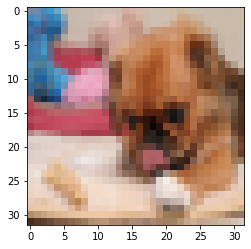

In [21]:
plt.imshow(sample_from[np.random.randint(0,sample_from.shape[0])])

### Ciclo de entrenamiento

In [22]:
# https://github.com/mrquincle/keras-adversarial-autoencoders/blob/master/Keras%20Adversarial%20Autoencoder%20MNIST.ipynb
epochs=7000
batch_size=500
sample_interval=500

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs+1):
    # lote de imagenes
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    latent_fake = encoder.predict(imgs)
    latent_true =true_sampler(dim_latente, batch_size)

    #entrenamos el discriminador
    dis_loss_real = discriminator.train_on_batch(latent_true, valid)
    dis_loss_fake = discriminator.train_on_batch(latent_fake, fake)
    dis_avg_loss = 0.5*np.add(dis_loss_fake, dis_loss_real)

    # entrenamos al autoencoder
    aae_loss = a_autoencoder.train_on_batch(imgs,[imgs, valid])
    
    # monitorizamos el progreso
    if epoch % 10==0:
        print("Epoch: %d Disc: (loss = %f, acc = %.2f%%) AAE: (mse = %f, b_ce = %f)" % (epoch, dis_avg_loss[0], 100*dis_avg_loss[1], aae_loss[0], aae_loss[1]))
    # Hacemos una muestra visual
    if epoch % sample_interval==0:
        # sample_imgs(sample_from, autoencoder, epoch)
        generate_samples(dim_latente, decoder, epoch)


Epoch: 0 Disc: (loss = 0.689157, acc = 38.00%) AAE: (mse = 0.285956, b_ce = 0.285558)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 10 Disc: (loss = 0.461749, acc = 97.10%) AAE: (mse = 0.178015, b_ce = 0.177456)
Epoch: 20 Disc: (loss = 0.353236, acc = 98.80%) AAE: (mse = 0.076695, b_ce = 0.075903)
Epoch: 30 Disc: (loss = 0.269420, acc = 99.50%) AAE: (mse = 0.075768, b_ce = 0.074789)
Epoch: 40 Disc: (loss = 0.223498, acc = 99.20%) AAE: (mse = 0.078775, b_ce = 0.077590)
Epoch: 50 Disc: (loss = 0.174843, acc = 98.60%) AAE: (mse = 0.070872, b_ce = 0.069456)
Epoch: 60 Disc: (loss = 0.136876, acc = 99.30%) AAE: (mse = 0.069829, b_ce = 0.068168)
Epoch: 70 Disc: (loss = 0.110934, acc = 99.30%) AAE: (mse = 0.065880, b_ce = 0.063973)
Epoch: 80 Disc: (loss = 0.089226, acc = 99.80%) AAE: (mse = 0.063516, b_ce = 0.061408)
Epoch: 90 Disc: (loss = 0.078324, acc = 99.50%) AAE: (mse = 0.064445, b_ce = 0.062147)
Epoch: 100 Disc: (loss = 0.070314, acc = 99.40%) AAE: (mse = 0.063780, b_ce = 0.061310)
Epoch: 110 Disc: (loss = 0.056410, acc = 99.40%) AAE: (mse = 0.063491, b_ce = 0.060780)
Epoch: 120 Disc: (loss = 0.042654, acc = 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 510 Disc: (loss = 0.003040, acc = 100.00%) AAE: (mse = 0.063902, b_ce = 0.058470)
Epoch: 520 Disc: (loss = 0.003016, acc = 100.00%) AAE: (mse = 0.066946, b_ce = 0.061496)
Epoch: 530 Disc: (loss = 0.002512, acc = 100.00%) AAE: (mse = 0.066134, b_ce = 0.060623)
Epoch: 540 Disc: (loss = 0.002545, acc = 100.00%) AAE: (mse = 0.067541, b_ce = 0.061999)
Epoch: 550 Disc: (loss = 0.002753, acc = 100.00%) AAE: (mse = 0.066249, b_ce = 0.060696)
Epoch: 560 Disc: (loss = 0.003364, acc = 100.00%) AAE: (mse = 0.064153, b_ce = 0.058598)
Epoch: 570 Disc: (loss = 0.002258, acc = 100.00%) AAE: (mse = 0.065952, b_ce = 0.060331)
Epoch: 580 Disc: (loss = 0.002312, acc = 100.00%) AAE: (mse = 0.063666, b_ce = 0.058035)
Epoch: 590 Disc: (loss = 0.002735, acc = 100.00%) AAE: (mse = 0.067364, b_ce = 0.061796)
Epoch: 600 Disc: (loss = 0.002230, acc = 100.00%) AAE: (mse = 0.066066, b_ce = 0.060356)
Epoch: 610 Disc: (loss = 0.002271, acc = 100.00%) AAE: (mse = 0.065512, b_ce = 0.059866)
Epoch: 620 Disc: (los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1010 Disc: (loss = 0.000510, acc = 100.00%) AAE: (mse = 0.067413, b_ce = 0.059927)
Epoch: 1020 Disc: (loss = 0.000347, acc = 100.00%) AAE: (mse = 0.067785, b_ce = 0.060174)
Epoch: 1030 Disc: (loss = 0.000344, acc = 100.00%) AAE: (mse = 0.066676, b_ce = 0.059026)
Epoch: 1040 Disc: (loss = 0.001190, acc = 100.00%) AAE: (mse = 0.069207, b_ce = 0.061518)
Epoch: 1050 Disc: (loss = 0.000313, acc = 100.00%) AAE: (mse = 0.066619, b_ce = 0.058944)
Epoch: 1060 Disc: (loss = 0.000525, acc = 100.00%) AAE: (mse = 0.068834, b_ce = 0.061070)
Epoch: 1070 Disc: (loss = 0.000422, acc = 100.00%) AAE: (mse = 0.068281, b_ce = 0.060462)
Epoch: 1080 Disc: (loss = 0.000366, acc = 100.00%) AAE: (mse = 0.066972, b_ce = 0.059116)
Epoch: 1090 Disc: (loss = 0.000347, acc = 100.00%) AAE: (mse = 0.067931, b_ce = 0.060032)
Epoch: 1100 Disc: (loss = 0.000291, acc = 100.00%) AAE: (mse = 0.071298, b_ce = 0.063436)
Epoch: 1110 Disc: (loss = 0.000351, acc = 100.00%) AAE: (mse = 0.068299, b_ce = 0.060327)
Epoch: 112

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1510 Disc: (loss = 0.000116, acc = 100.00%) AAE: (mse = 0.069336, b_ce = 0.060210)
Epoch: 1520 Disc: (loss = 0.000871, acc = 99.90%) AAE: (mse = 0.069836, b_ce = 0.060727)
Epoch: 1530 Disc: (loss = 0.000184, acc = 100.00%) AAE: (mse = 0.066473, b_ce = 0.057644)
Epoch: 1540 Disc: (loss = 0.000167, acc = 100.00%) AAE: (mse = 0.070517, b_ce = 0.061375)
Epoch: 1550 Disc: (loss = 0.000538, acc = 100.00%) AAE: (mse = 0.070430, b_ce = 0.061561)
Epoch: 1560 Disc: (loss = 0.000125, acc = 100.00%) AAE: (mse = 0.068990, b_ce = 0.059971)
Epoch: 1570 Disc: (loss = 0.000127, acc = 100.00%) AAE: (mse = 0.068926, b_ce = 0.059891)
Epoch: 1580 Disc: (loss = 0.000119, acc = 100.00%) AAE: (mse = 0.069558, b_ce = 0.060255)
Epoch: 1590 Disc: (loss = 0.000088, acc = 100.00%) AAE: (mse = 0.068847, b_ce = 0.059641)
Epoch: 1600 Disc: (loss = 0.000118, acc = 100.00%) AAE: (mse = 0.070024, b_ce = 0.060690)
Epoch: 1610 Disc: (loss = 0.000092, acc = 100.00%) AAE: (mse = 0.069482, b_ce = 0.060143)
Epoch: 1620

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2010 Disc: (loss = 0.002041, acc = 99.90%) AAE: (mse = 0.070262, b_ce = 0.060739)
Epoch: 2020 Disc: (loss = 0.000052, acc = 100.00%) AAE: (mse = 0.072161, b_ce = 0.062236)
Epoch: 2030 Disc: (loss = 0.000070, acc = 100.00%) AAE: (mse = 0.071014, b_ce = 0.060946)
Epoch: 2040 Disc: (loss = 0.000309, acc = 100.00%) AAE: (mse = 0.070192, b_ce = 0.059876)
Epoch: 2050 Disc: (loss = 0.000054, acc = 100.00%) AAE: (mse = 0.072205, b_ce = 0.061795)
Epoch: 2060 Disc: (loss = 0.000020, acc = 100.00%) AAE: (mse = 0.071058, b_ce = 0.060346)
Epoch: 2070 Disc: (loss = 0.000092, acc = 100.00%) AAE: (mse = 0.071976, b_ce = 0.061656)
Epoch: 2080 Disc: (loss = 0.000406, acc = 100.00%) AAE: (mse = 0.071392, b_ce = 0.061677)
Epoch: 2090 Disc: (loss = 0.000044, acc = 100.00%) AAE: (mse = 0.071914, b_ce = 0.061768)
Epoch: 2100 Disc: (loss = 0.000036, acc = 100.00%) AAE: (mse = 0.072124, b_ce = 0.061533)
Epoch: 2110 Disc: (loss = 0.000117, acc = 100.00%) AAE: (mse = 0.070672, b_ce = 0.060491)
Epoch: 2120

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2510 Disc: (loss = 0.000072, acc = 100.00%) AAE: (mse = 0.072596, b_ce = 0.062000)
Epoch: 2520 Disc: (loss = 0.000043, acc = 100.00%) AAE: (mse = 0.069692, b_ce = 0.058692)
Epoch: 2530 Disc: (loss = 0.000013, acc = 100.00%) AAE: (mse = 0.071141, b_ce = 0.059955)
Epoch: 2540 Disc: (loss = 0.000048, acc = 100.00%) AAE: (mse = 0.072716, b_ce = 0.061366)
Epoch: 2550 Disc: (loss = 0.000319, acc = 100.00%) AAE: (mse = 0.072901, b_ce = 0.062876)
Epoch: 2560 Disc: (loss = 0.000060, acc = 100.00%) AAE: (mse = 0.072359, b_ce = 0.062068)
Epoch: 2570 Disc: (loss = 0.000022, acc = 100.00%) AAE: (mse = 0.070390, b_ce = 0.059460)
Epoch: 2580 Disc: (loss = 0.000013, acc = 100.00%) AAE: (mse = 0.072104, b_ce = 0.060988)
Epoch: 2590 Disc: (loss = 0.000110, acc = 100.00%) AAE: (mse = 0.072767, b_ce = 0.061926)
Epoch: 2600 Disc: (loss = 0.000026, acc = 100.00%) AAE: (mse = 0.069978, b_ce = 0.059183)
Epoch: 2610 Disc: (loss = 0.000075, acc = 100.00%) AAE: (mse = 0.070971, b_ce = 0.060737)
Epoch: 262

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 3010 Disc: (loss = 0.000046, acc = 100.00%) AAE: (mse = 0.074366, b_ce = 0.064006)
Epoch: 3020 Disc: (loss = 0.000014, acc = 100.00%) AAE: (mse = 0.071777, b_ce = 0.059752)
Epoch: 3030 Disc: (loss = 0.000091, acc = 100.00%) AAE: (mse = 0.071796, b_ce = 0.060221)
Epoch: 3040 Disc: (loss = 0.000281, acc = 100.00%) AAE: (mse = 0.068758, b_ce = 0.058589)
Epoch: 3050 Disc: (loss = 0.000022, acc = 100.00%) AAE: (mse = 0.071514, b_ce = 0.060159)
Epoch: 3060 Disc: (loss = 0.000008, acc = 100.00%) AAE: (mse = 0.073212, b_ce = 0.061636)
Epoch: 3070 Disc: (loss = 0.000010, acc = 100.00%) AAE: (mse = 0.073520, b_ce = 0.061763)
Epoch: 3080 Disc: (loss = 0.000017, acc = 100.00%) AAE: (mse = 0.070235, b_ce = 0.059346)
Epoch: 3090 Disc: (loss = 0.000075, acc = 100.00%) AAE: (mse = 0.072783, b_ce = 0.061699)
Epoch: 3100 Disc: (loss = 0.000006, acc = 100.00%) AAE: (mse = 0.069967, b_ce = 0.058383)
Epoch: 3110 Disc: (loss = 0.000145, acc = 100.00%) AAE: (mse = 0.071111, b_ce = 0.059477)
Epoch: 312

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 3510 Disc: (loss = 0.000214, acc = 100.00%) AAE: (mse = 0.071571, b_ce = 0.059680)
Epoch: 3520 Disc: (loss = 0.000351, acc = 100.00%) AAE: (mse = 0.071792, b_ce = 0.060556)
Epoch: 3530 Disc: (loss = 0.000011, acc = 100.00%) AAE: (mse = 0.072717, b_ce = 0.060438)
Epoch: 3540 Disc: (loss = 0.000027, acc = 100.00%) AAE: (mse = 0.073604, b_ce = 0.061792)
Epoch: 3550 Disc: (loss = 0.000006, acc = 100.00%) AAE: (mse = 0.072581, b_ce = 0.060310)
Epoch: 3560 Disc: (loss = 0.000013, acc = 100.00%) AAE: (mse = 0.069740, b_ce = 0.058131)
Epoch: 3570 Disc: (loss = 0.000830, acc = 100.00%) AAE: (mse = 0.071081, b_ce = 0.059449)
Epoch: 3580 Disc: (loss = 0.000003, acc = 100.00%) AAE: (mse = 0.072164, b_ce = 0.058291)
Epoch: 3590 Disc: (loss = 0.000038, acc = 100.00%) AAE: (mse = 0.074044, b_ce = 0.060154)
Epoch: 3600 Disc: (loss = 0.000040, acc = 100.00%) AAE: (mse = 0.073203, b_ce = 0.061076)
Epoch: 3610 Disc: (loss = 0.000018, acc = 100.00%) AAE: (mse = 0.074046, b_ce = 0.061510)
Epoch: 362

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 4010 Disc: (loss = 0.000078, acc = 100.00%) AAE: (mse = 0.070586, b_ce = 0.058539)
Epoch: 4020 Disc: (loss = 0.005252, acc = 99.90%) AAE: (mse = 0.072420, b_ce = 0.061099)
Epoch: 4030 Disc: (loss = 0.000041, acc = 100.00%) AAE: (mse = 0.070800, b_ce = 0.059222)
Epoch: 4040 Disc: (loss = 0.000008, acc = 100.00%) AAE: (mse = 0.071262, b_ce = 0.058659)
Epoch: 4050 Disc: (loss = 0.000125, acc = 100.00%) AAE: (mse = 0.074140, b_ce = 0.061207)
Epoch: 4060 Disc: (loss = 0.000003, acc = 100.00%) AAE: (mse = 0.076477, b_ce = 0.063124)
Epoch: 4070 Disc: (loss = 0.000095, acc = 100.00%) AAE: (mse = 0.068986, b_ce = 0.057522)
Epoch: 4080 Disc: (loss = 0.000068, acc = 100.00%) AAE: (mse = 0.072354, b_ce = 0.060644)
Epoch: 4090 Disc: (loss = 0.000029, acc = 100.00%) AAE: (mse = 0.072541, b_ce = 0.057904)
Epoch: 4100 Disc: (loss = 0.000006, acc = 100.00%) AAE: (mse = 0.074626, b_ce = 0.061295)
Epoch: 4110 Disc: (loss = 0.000008, acc = 100.00%) AAE: (mse = 0.075512, b_ce = 0.062296)
Epoch: 4120

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 4510 Disc: (loss = 0.000005, acc = 100.00%) AAE: (mse = 0.072820, b_ce = 0.059125)
Epoch: 4520 Disc: (loss = 0.000024, acc = 100.00%) AAE: (mse = 0.071799, b_ce = 0.058074)
Epoch: 4530 Disc: (loss = 0.000052, acc = 100.00%) AAE: (mse = 0.075237, b_ce = 0.061541)
Epoch: 4540 Disc: (loss = 0.000034, acc = 100.00%) AAE: (mse = 0.074039, b_ce = 0.060686)
Epoch: 4550 Disc: (loss = 0.000005, acc = 100.00%) AAE: (mse = 0.074262, b_ce = 0.061401)
Epoch: 4560 Disc: (loss = 0.000011, acc = 100.00%) AAE: (mse = 0.073651, b_ce = 0.060003)
Epoch: 4570 Disc: (loss = 0.000012, acc = 100.00%) AAE: (mse = 0.071913, b_ce = 0.058644)
Epoch: 4580 Disc: (loss = 0.000068, acc = 100.00%) AAE: (mse = 0.068412, b_ce = 0.056931)
Epoch: 4590 Disc: (loss = 0.000015, acc = 100.00%) AAE: (mse = 0.072444, b_ce = 0.060221)
Epoch: 4600 Disc: (loss = 0.001010, acc = 99.90%) AAE: (mse = 0.073271, b_ce = 0.060702)
Epoch: 4610 Disc: (loss = 0.001505, acc = 99.90%) AAE: (mse = 0.075659, b_ce = 0.063431)
Epoch: 4620 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 5010 Disc: (loss = 0.000156, acc = 100.00%) AAE: (mse = 0.072308, b_ce = 0.060505)
Epoch: 5020 Disc: (loss = 0.000078, acc = 100.00%) AAE: (mse = 0.072808, b_ce = 0.060267)
Epoch: 5030 Disc: (loss = 0.000012, acc = 100.00%) AAE: (mse = 0.073811, b_ce = 0.061134)
Epoch: 5040 Disc: (loss = 0.000280, acc = 100.00%) AAE: (mse = 0.072177, b_ce = 0.059962)
Epoch: 5050 Disc: (loss = 0.001295, acc = 99.90%) AAE: (mse = 0.069368, b_ce = 0.057918)
Epoch: 5060 Disc: (loss = 0.000024, acc = 100.00%) AAE: (mse = 0.072684, b_ce = 0.060589)
Epoch: 5070 Disc: (loss = 0.000443, acc = 100.00%) AAE: (mse = 0.071876, b_ce = 0.060631)
Epoch: 5080 Disc: (loss = 0.000003, acc = 100.00%) AAE: (mse = 0.075882, b_ce = 0.061300)
Epoch: 5090 Disc: (loss = 0.000054, acc = 100.00%) AAE: (mse = 0.073543, b_ce = 0.061095)
Epoch: 5100 Disc: (loss = 0.000269, acc = 100.00%) AAE: (mse = 0.070352, b_ce = 0.057349)
Epoch: 5110 Disc: (loss = 0.000026, acc = 100.00%) AAE: (mse = 0.073399, b_ce = 0.060614)
Epoch: 5120

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 5510 Disc: (loss = 0.000012, acc = 100.00%) AAE: (mse = 0.073157, b_ce = 0.059582)
Epoch: 5520 Disc: (loss = 0.000005, acc = 100.00%) AAE: (mse = 0.072014, b_ce = 0.058503)
Epoch: 5530 Disc: (loss = 0.000010, acc = 100.00%) AAE: (mse = 0.072632, b_ce = 0.059817)
Epoch: 5540 Disc: (loss = 0.000024, acc = 100.00%) AAE: (mse = 0.073748, b_ce = 0.060937)
Epoch: 5550 Disc: (loss = 0.002846, acc = 99.90%) AAE: (mse = 0.073918, b_ce = 0.061147)
Epoch: 5560 Disc: (loss = 0.000057, acc = 100.00%) AAE: (mse = 0.075979, b_ce = 0.061336)
Epoch: 5570 Disc: (loss = 0.000020, acc = 100.00%) AAE: (mse = 0.070471, b_ce = 0.058735)
Epoch: 5580 Disc: (loss = 0.000258, acc = 100.00%) AAE: (mse = 0.073073, b_ce = 0.058031)
Epoch: 5590 Disc: (loss = 0.000011, acc = 100.00%) AAE: (mse = 0.075371, b_ce = 0.060942)
Epoch: 5600 Disc: (loss = 0.001460, acc = 99.90%) AAE: (mse = 0.075961, b_ce = 0.063257)
Epoch: 5610 Disc: (loss = 0.000045, acc = 100.00%) AAE: (mse = 0.073223, b_ce = 0.060221)
Epoch: 5620 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 6010 Disc: (loss = 0.000003, acc = 100.00%) AAE: (mse = 0.072475, b_ce = 0.059243)
Epoch: 6020 Disc: (loss = 0.000005, acc = 100.00%) AAE: (mse = 0.072472, b_ce = 0.059410)
Epoch: 6030 Disc: (loss = 0.000004, acc = 100.00%) AAE: (mse = 0.069153, b_ce = 0.056527)
Epoch: 6040 Disc: (loss = 0.000018, acc = 100.00%) AAE: (mse = 0.073616, b_ce = 0.060613)
Epoch: 6050 Disc: (loss = 0.000003, acc = 100.00%) AAE: (mse = 0.073082, b_ce = 0.060015)
Epoch: 6060 Disc: (loss = 0.001675, acc = 99.90%) AAE: (mse = 0.072289, b_ce = 0.060573)
Epoch: 6070 Disc: (loss = 0.000038, acc = 100.00%) AAE: (mse = 0.073514, b_ce = 0.060702)
Epoch: 6080 Disc: (loss = 0.000107, acc = 100.00%) AAE: (mse = 0.073447, b_ce = 0.061291)
Epoch: 6090 Disc: (loss = 0.001697, acc = 99.90%) AAE: (mse = 0.069338, b_ce = 0.058421)
Epoch: 6100 Disc: (loss = 0.000170, acc = 100.00%) AAE: (mse = 0.074024, b_ce = 0.060759)
Epoch: 6110 Disc: (loss = 0.000738, acc = 99.90%) AAE: (mse = 0.073123, b_ce = 0.060947)
Epoch: 6120 D

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 6510 Disc: (loss = 0.000288, acc = 100.00%) AAE: (mse = 0.070816, b_ce = 0.058924)
Epoch: 6520 Disc: (loss = 0.000005, acc = 100.00%) AAE: (mse = 0.075117, b_ce = 0.061324)
Epoch: 6530 Disc: (loss = 0.000078, acc = 100.00%) AAE: (mse = 0.071550, b_ce = 0.059763)
Epoch: 6540 Disc: (loss = 0.000917, acc = 99.90%) AAE: (mse = 0.071505, b_ce = 0.059889)
Epoch: 6550 Disc: (loss = 0.000061, acc = 100.00%) AAE: (mse = 0.072122, b_ce = 0.059297)
Epoch: 6560 Disc: (loss = 0.000074, acc = 100.00%) AAE: (mse = 0.072172, b_ce = 0.059928)
Epoch: 6570 Disc: (loss = 0.000078, acc = 100.00%) AAE: (mse = 0.073808, b_ce = 0.061422)
Epoch: 6580 Disc: (loss = 0.000007, acc = 100.00%) AAE: (mse = 0.073571, b_ce = 0.059769)
Epoch: 6590 Disc: (loss = 0.000031, acc = 100.00%) AAE: (mse = 0.073146, b_ce = 0.060777)
Epoch: 6600 Disc: (loss = 0.000014, acc = 100.00%) AAE: (mse = 0.070979, b_ce = 0.058823)
Epoch: 6610 Disc: (loss = 0.000055, acc = 100.00%) AAE: (mse = 0.068417, b_ce = 0.056983)
Epoch: 6620

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

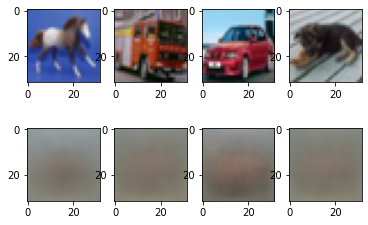

In [28]:
sample_imgs(sample_from, a_autoencoder, 0, 4, False)

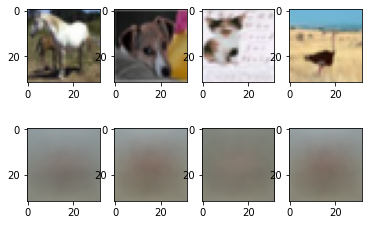

In [29]:
sample_imgs(X_train, a_autoencoder, 0, 4, False)

In [27]:
import os.path

savefile = "AdversarialAutoEncoder/a_autoencoder.h5"

if not os.path.isfile(savefile):
    a_autoencoder.save(savefile)
else:
    print("Ya hay un modelo guardado en "+savefile)